# 2D Bicopter (Quadcopter)

We consider the 2D (vertical $z$ and horizontal axis $y$) quadcopter problem, and consider the following dynamics


State: $$[y, z, v_y, v_z]$$

Near hover Dynamics:
$$\begin{bmatrix}\dot y \\ \dot z \\ \dot v_y\\ \dot v_z\end{bmatrix} = \begin{bmatrix}v_x \\ v_y \\ -T \sin(\phi) \\ T \cos(\phi) - g\end{bmatrix}, \text{with } u=[\phi, T]$$


Approximation of near hover Dynamics: 
$$\begin{bmatrix}\dot y \\ \dot z \\ \dot v_y \\ \dot v_z\end{bmatrix}=\dot{X}=\begin{bmatrix}v_y \\ v_z \\-g\tan(\phi) \\ T-g\end{bmatrix}=\begin{bmatrix}v_y \\ v_z \\ -gu_1 \\ u_2 - g\end{bmatrix}, \text{with } u=[\tan(\phi), T]$$

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys; sys.version

'3.9.18 | packaged by conda-forge | (main, Aug 30 2023, 03:49:32) \n[GCC 12.3.0]'

In [3]:
import matplotlib
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'font.size': '20',
    'text.usetex': False,   # Toggle to true for official LaTeX output
    'pgf.rcfonts': False,
    'lines.linewidth': 4.,
})

In [4]:
import warnings
# warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
from matplotlib import MatplotlibDeprecationWarning
warnings.filterwarnings("ignore", category=MatplotlibDeprecationWarning)
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
import numpy as np

import copy

from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import HTML

In [5]:
import cbf_opt
from cbf_opt import ControlAffineDynamics, ControlAffineCBF, ControlAffineASIF, SlackifiedControlAffineASIF, BatchedDynamics
from experiment_wrapper import RolloutTrajectory, StateSpaceExperiment, TimeSeriesExperiment

## Setup Problem (dynamics, environment and CBF)

### Dynamics

In [6]:
import numpy as np


class CrazyflieDynamics(ControlAffineDynamics):
    """
    Simplified dynamics, and we need to convert controls from phi to tan(phi)"""
    STATES = ["y", "z", "v_y", "v_z"]
    CONTROLS = ["tan(phi)", "T"]
    DISTURBANCES = ["dy", "dz"]
    def __init__(self, params, test=True, **kwargs):
        super().__init__(params=params, test=test, **kwargs)
    
    def open_loop_dynamics(self, state, time: float = 0.0):
        return jnp.array([state[2], state[3], 0.0, -self.params['g']])

    def control_matrix(self, state, time: float = 0.0):
        return jnp.array([[0.0, 0.0], [0.0, 0.0], [self.params['g'], 0.0], [0.0, 1.0]])
    
    def disturbance_matrix(self, state, time: float = 0):
        return jnp.array([[1.0, 0.0], [0.0, 1.0], [0.0, 0.0], [0.0, 0.0]]).reshape(len(self.STATES), len(self.DISTURBANCES))
    
    def state_jacobian(self, state, control, disturbance = None, time: float = 0.0):
        return jax.jacfwd(lambda x: self.__call__(x, control, disturbance, time))(state)
    

In [7]:
dyn_params = {'g': 9.81}
dyn = CrazyflieDynamics(params=dyn_params, test=False, dt=0.01)
batched_dyn = BatchedDynamics(dyn)
umax = jnp.array([jnp.tan(np.pi / 6), 1.5 * 9.81])
umin = jnp.array([-jnp.tan(np.pi / 6), 0.0])

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


### Initial Control Barrier Function

In [8]:
class CrazyflieCBF(ControlAffineCBF):
    def __init__(self, dynamics, params, test=False, **kwargs):
        self.scaling = params["scaling"]
        self.center = params["center"]
        self.offset = params["offset"]
        self._vf_grad = jax.vmap(jax.grad(self.vf, argnums=0), in_axes=(0, None))
        super().__init__(dynamics, params=params, test=False, **kwargs)
    
    def vf(self, state, time=0.0):
        val = (self.offset - jnp.sum(self.scaling * (state - self.center) ** 2, axis=-1))
        return val
        # return jnp.where(val > 0, val, 0.1 * val)
    
    def _grad_vf(self, state, time=0.0):
        return self._vf_grad(state, time)

In [9]:
cbf_cf_params = {"scaling": jnp.array([2.0, 2.0, 1.0, 1.0]), "offset": 2.0, "center": jnp.array([-3.5, 2., 0.0, 0.])}
cbf_cf = CrazyflieCBF(batched_dyn, cbf_cf_params, test=False)

In [10]:
Lfs, Lgs, Lws = cbf_cf.lie_derivatives(jnp.array([[0., 0., 0., 0.]]), jnp.array([0.0]))

## Online implementation

### Nominal control
We consider an LQR controller for nominal control. If you modify the experiment you can see that an LQR controller with safety filter is safe but can lead to us getting stuck

In [11]:
x_nom = jnp.array([0.0, 3.0, 0.0, 0.0])
u_nom = jnp.array([0.0, 9.81])
A, B, D = dyn.linearized_dt_dynamics(x_nom, u_nom)

Q = jnp.diag(jnp.array([1.0, 1.0, 0.1, 0.1]))
R = jnp.diag(jnp.array([1.0, 1.0]))

K = cbf_opt.utils.lqr(A, B, Q, R)

A_cl = A - B @ K
# assert np.all(np.linalg.eigvals(A_cl) < 0).all() 

In [12]:
nominal_control = lambda u_ref, x_ref, F: lambda x, t: np.atleast_2d(np.clip(u_ref - 
                                (F @ (x - x_ref).T).T, umin, umax))

### Safety filter
We use the slackified version of the safety filter to ensure , we use gurobi as a solver (you need to obtain an academic license, or change the solver to e.g. "ECOS" / "OSQP")

In [13]:
x_goal = jnp.array([4.0, 1.0, 0.0, 0.0])
u_goal = jnp.array([0.0, 9.81])
import cvxpy as cp
nom_control = nominal_control(u_goal, x_goal, K)
alpha = lambda x: 3.0 * x

cbf_asif = SlackifiedControlAffineASIF(batched_dyn, cbf_cf, test=False, alpha=alpha, nominal_policy=nom_control,
                                       umin=umin, umax=umax, solver=cp.GUROBI)

In [14]:
nom_control(x_nom, 0.0).shape

(1, 2)

In [15]:
dyn_2 = CrazyflieDynamics({"g": 9.81}, test=False, dt=0.01)
dyn_3 = CrazyflieDynamics({"g": 6.0}, test=False, dt=0.01)
batched_dyn_2 = BatchedDynamics(dyn_2)
batched_dyn_3 = BatchedDynamics(dyn_3)

actual_dyn = CrazyflieDynamics({"g": 8.0}, test=False, dt=0.01)

cbf2 = CrazyflieCBF(batched_dyn_2, cbf_cf_params, test=False)
cbf3 = CrazyflieCBF(batched_dyn_3, cbf_cf_params, test=False)
asif2 = SlackifiedControlAffineASIF(batched_dyn_2, cbf2, test=False, alpha=alpha, nominal_policy=nom_control,
                                    umin=umin, umax=umax, solver=cp.GUROBI)
asif3 = SlackifiedControlAffineASIF(batched_dyn_3, cbf3, test=False, alpha=alpha, nominal_policy=nom_control,
                                    umin=umin, umax=umax, solver=cp.GUROBI)

In [16]:
x0 = jnp.array([-4.0, 2.0, 0.0, 0.0])
experiment = RolloutTrajectory('quad', start_x=x0, n_sims_per_start=1, t_sim=20.0)

In [17]:
class UniformDisturbance:
    def __init__(self, bounds, **kwargs):
        self.bounds = bounds
        self.seed = kwargs.get("seed", 0)
        self.beta_skew = kwargs.get("beta_skew", 1.0)  # Defaults to a uniform distribution
        self.reset()
    
    def __call__(self, x, t):
        return self.random_state.beta(self.beta_skew, self.beta_skew, size=(x.shape[0], self.bounds.shape[0])) * (self.bounds[:, 1] - self.bounds[:, 0]) + self.bounds[:, 0]
    
    def reset(self, x=None):
        self.random_state = np.random.default_rng(seed=self.seed)

In [18]:
dist = UniformDisturbance(bounds=np.array([[-5, 5], [-0.1, 0.1]]), seed=0)
dist2 = UniformDisturbance(bounds=np.array([[-5, 5], [-0.1, 0.1]]), seed=0, beta_skew=0.5)

In [19]:
import logging
logging.getLogger('cbf_opt').setLevel(level=logging.ERROR)
results_df = experiment.run(batched_dyn, {"nominal": nom_control}, disturbances= {"uniform": dist, "tail": dist2})#, "CBF": cbf_asif, "High gravity CBF": asif2, "Low gravity CBF": asif3})

Controller rollout: 100%|██████████| 2000/2000 [00:06<00:00, 331.63it/s]


In [20]:
# Find closest time in results_df.t to time_ind
def find_closest_time(df, time_ind):
    return df.t.iloc[df.t.sub(time_ind).abs().idxmin()]


ss_exp = StateSpaceExperiment('quad', x_indices=[0, 1], start_x=x0)
# Set up the figure and axis
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
alphas = [0.1, 0.5, 0.5, 1.0]
nbr_controllers = len(results_df.controller.unique())

# ax.contour(grid.coordinate_vectors[0], grid.coordinate_vectors[1],
#             tabular_cbf.vf_table[:, :, grid.shape[2] // 2, grid.shape[3] // 2].T, levels=[0], colors='grey')

plt.legend(results_df.controller.unique())
ax.set_xlabel('$y$ (Horizontal)', fontsize=20)
ax.set_ylabel('$z$ (Vertical)', fontsize=20)
tx = ax.set_title('$v_y=0, v_z=0$, HJR time $t=0$')
ss_exp.plot(batched_dyn, results_df, ax=ax, add_direction=False, max_time=0.0, alpha=alphas)
ax.legend(ax.lines[::len(ax.lines) // nbr_controllers], results_df.controller.unique(), loc="upper center", ncol=4, fontsize=10)
# ax.set_xlim([min(results_df[results_df.measurement == "y"].value) - 0.5, max(results_df[results_df.measurement == "y"].value) + 0.5])
# ax.set_ylim([min(results_df[results_df.measurement == "z"].value) - 0.5, max(results_df[results_df.measurement == "z"].value) + 0.5])
# Update function to draw contours for a given idi value
def update(time):
    # ax.clear()
    for line in ax.lines:
        line.remove()
    for patch in ax.patches:
        patch.remove()
    ax.set_prop_cycle(None)
    ss_exp.plot(batched_dyn, results_df, ax=ax, add_direction=False, max_time=time, alpha=alphas)
    closest_time = find_closest_time(results_df, time)
    colors = []
    for line in ax.lines[::len(ax.lines) // nbr_controllers]:
        colors.append(line.get_color())
    tx.set_text('$v_y=0, v_z=0$, Simulation time t={:.2f}'.format(np.abs(time)))
fig.tight_layout()

ani = FuncAnimation(fig, update, frames=np.linspace(0,20,100))
plt.close()
HTML(ani.to_jshtml())

In [21]:
ts_exp = TimeSeriesExperiment('quad', x_indices=[0, 1], d_indices=[0, 1], start_x=x0)

Measurement vf not in results dataframe


[('Rollout (time series)', <Figure size 1000x2400 with 6 Axes>)]

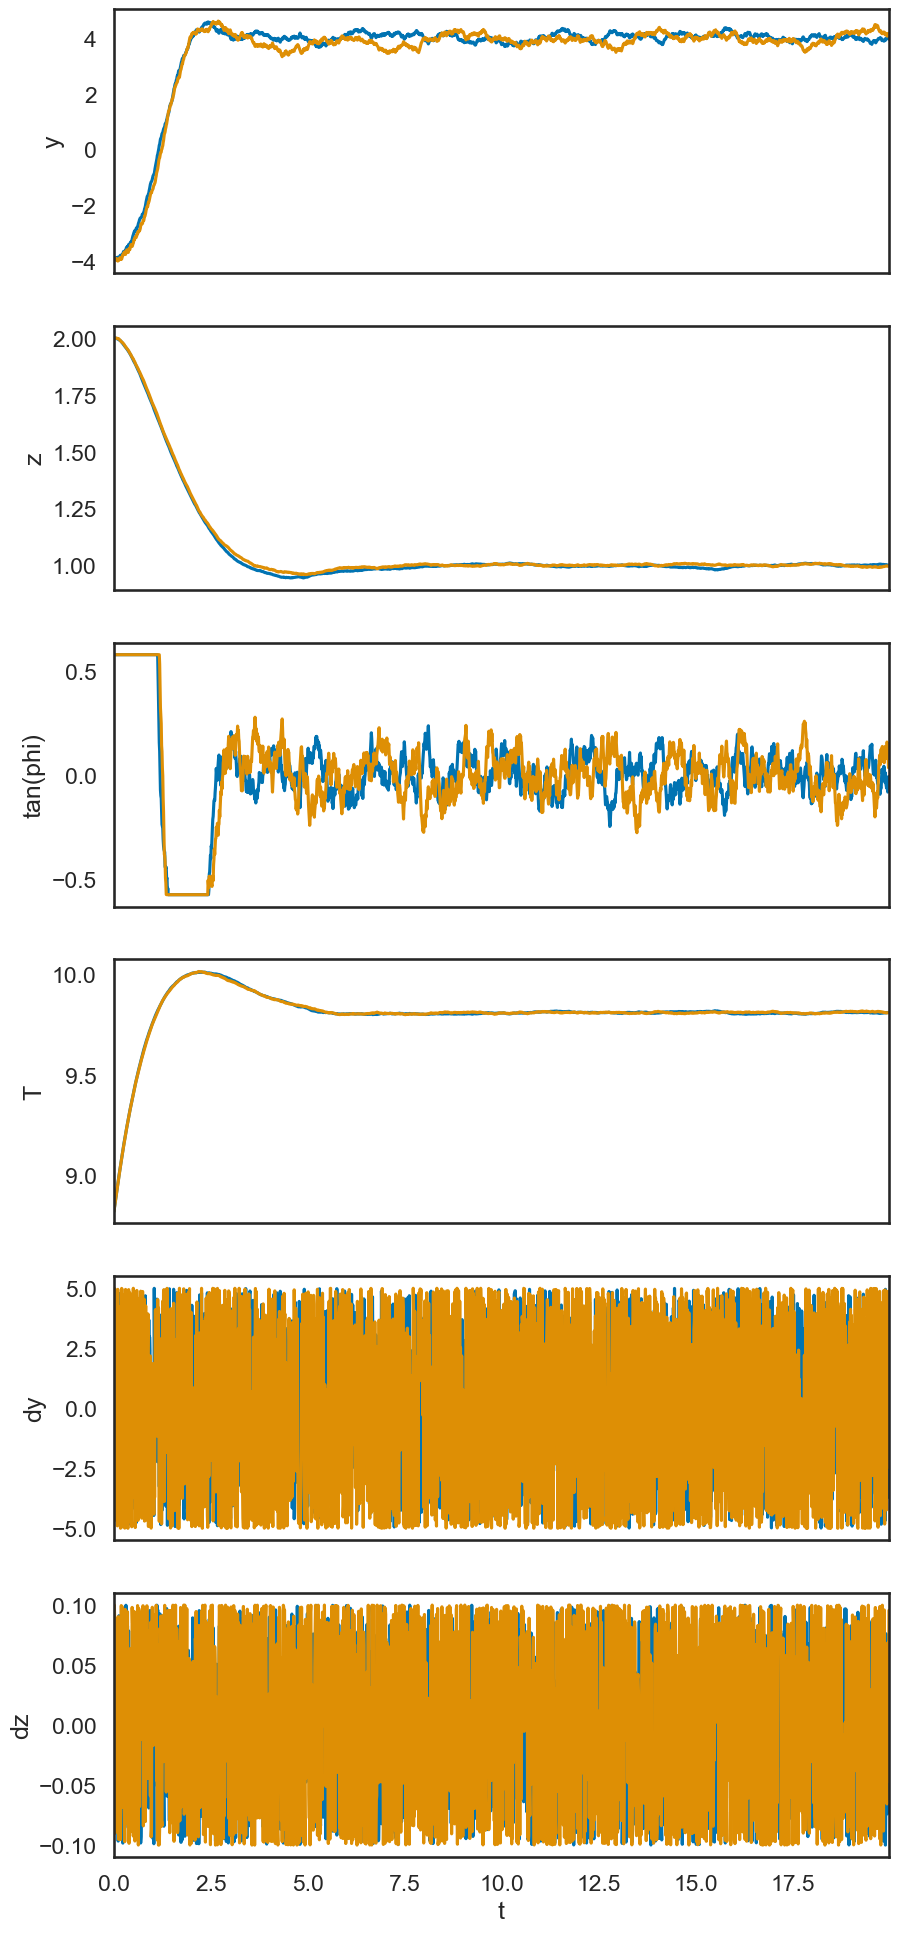

In [22]:
ts_exp.plot(batched_dyn_2, results_df, extra_measurements=['vf'])